# Top Model Results and Analysis

In [2]:
import warnings
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import geopandas

import pyarrow
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from scipy.stats import spearmanr
from scipy.linalg import LinAlgWarning
from scipy.stats import pearsonr

import pickle
import math
import seaborn as sns

In [56]:
%%html
<style>
table {float:left}
</style>

## Model parameters

Appriximately 10 parameters were varied during model optimization. Our best performing model was determined to use Landsat 8 imagery. A table o and bands 1-7 . Parameters varied The parameters chosen  top model was Landsat 8



Parameters      | Value
-------------   | ------------- 
Satellite       | Landsat 8 / Sentinel 2   
Bands           | 1-2-3-4-5-6-7
Years           | 2014-2018
Months          | 4-9
Number of points| 15,000
Crop mask       | None
Weighted averge | None
Train **n**     | 272
Test **n**      | 68

## Load model

In [4]:
# load model

filename = 'data/results/final_model.sav'

ridge_cv_random_loaded = pickle.load(open(filename, 'rb'))

print(f"Validation R2 performance {ridge_cv_random_loaded.best_score_:0.2f}")

Validation R2 performance 0.58


In [57]:
ridge_cv_random_loaded

RidgeCV(alphas=array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08]),
        cv=5)

## Import Zambia shapefile

In [10]:
country_code = "ZMB"
num_features = 1000
data_dir = "/capstone/cropmosaiks/data"

In [27]:
country_shp = geopandas.read_file(f'{data_dir}/boundaries/gadm36_{country_code}_2.shp')
country_shp = country_shp.rename(columns = {'NAME_2': 'district'})[['district', 'geometry']]
country_shp.district = country_shp.district.replace("MPongwe", 'Mpongwe', regex=True)
country_districts = country_shp.district.sort_values().unique().tolist()
country_shp = country_shp.set_index('district')
country_shp.shape
# country_shp.plot(figsize = (12,10), linewidth = 1, edgecolor = 'black' )
# country_shp.plot()

(72, 1)

## Import Zambia Crop Data

In [15]:
crop_df = pd.read_csv(data_dir+'/crops/cfs_maize_districts_zambia_2009_2018.csv')
crop_df.district = crop_df.district.replace(
    {"Itezhi-tezhi": 'Itezhi-Tezhi',
     "Kapiri-Mposhi": 'Kapiri Mposhi',
     "Shang'ombo": 'Shangombo',
     "Chienge": 'Chiengi'
    }, regex=True)
crop_districts = crop_df.district.sort_values().unique().tolist()
crop_df = crop_df[['district', 'year', 'yield_mt']]
ln = len(crop_df[crop_df.year == 2016].district)
crop_df = crop_df.set_index('district')

## Convert to GeoDataFrame and Merge Shapefile with Crop Data

In [20]:
country_crop = geopandas.GeoDataFrame(crop_df.join(country_shp), crs = country_shp.crs)

In [71]:
country_crop.head()

,year,yield_mt,geometry
district,,,
Chadiza,2009,1.333924,"POLYGON ((32.31720 -13.95683, 32.33500 -13.965..."
Chadiza,2010,1.852544,"POLYGON ((32.31720 -13.95683, 32.33500 -13.965..."
Chadiza,2011,6.846486,"POLYGON ((32.31720 -13.95683, 32.33500 -13.965..."
Chadiza,2012,2.148661,"POLYGON ((32.31720 -13.95683, 32.33500 -13.965..."
Chadiza,2013,2.008807,"POLYGON ((32.31720 -13.95683, 32.33500 -13.965..."


In [75]:
import math

In [81]:
country_crop['yield_mt_all'] = country_crop.math.log10('yield_mt')

AttributeError: 'GeoDataFrame' object has no attribute 'math'

In [ ]:

country_crop['yield_mt_converted'] = country_crop[country_crop.yield_mt]

### Plot individual year

<Figure size 432x288 with 0 Axes>

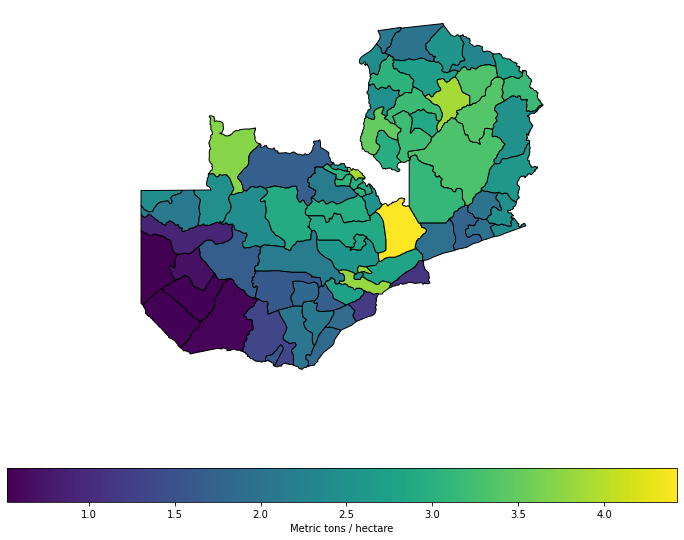

In [70]:
crop_year = 2014

plt.figure()
country_crop[country_crop.year == crop_year].plot(figsize = (12,10),
                                                  column = 'yield_mt',
                                                  legend = True,
                                                  legend_kwds = {'label': 'Metric tons / hectare','orientation': 'horizontal'},
                                                  linewidth = 1,
                                                  edgecolor = 'black')
plt.axis('off')

plt.savefig(f'images/{crop_year}_yield_CSO_data.png', dpi=300, transparent=True)

## Import Imputed Features

In [66]:
features_copy = pd.read_feather(f"{data_dir}/features/final_model_imputed_features.feather")

In [65]:
features_copy.head()

,year,0_4,0_5,0_6,0_7,0_8,0_9,1_4,1_5,1_6,...,998_9,999_4,999_5,999_6,999_7,999_8,999_9,crop_perc,district,geometry
0,2014,2.796088,2.169905,1.877239,1.058961,0.874885,1.043665,3.728270,3.899104,4.706322,...,2.577646,6.166853,6.677697,8.116331,8.290212,8.556185,8.622112,0.0,Kalabo,b'\x01\x01\x00\x00\x00L\xcf\xe8\xc1\x18\x006@\...
1,2015,1.746281,1.908137,1.600143,1.195653,1.250450,1.112692,4.794718,5.982648,5.623389,...,2.806297,8.181073,9.834212,9.577337,9.478734,10.115788,9.887067,0.0,Kalabo,b'\x01\x01\x00\x00\x00L\xcf\xe8\xc1\x18\x006@\...
2,2016,2.224097,2.074300,1.898633,1.076144,1.037122,0.774001,5.436888,5.968930,5.416975,...,2.704272,9.098929,9.766782,9.202447,9.824132,9.903685,9.594785,0.0,Kalabo,b'\x01\x01\x00\x00\x00L\xcf\xe8\xc1\x18\x006@\...
3,2017,2.587581,3.022594,2.533386,2.202421,1.629587,1.223843,4.188748,4.911941,5.379704,...,2.703153,6.933536,7.877261,8.821350,9.190662,9.328294,9.175184,0.0,Kalabo,b'\x01\x01\x00\x00\x00L\xcf\xe8\xc1\x18\x006@\...
4,2018,2.563579,2.783937,1.787531,2.116021,1.039855,1.102192,3.424892,3.876993,4.317358,...,2.588604,5.816585,6.415036,7.585889,9.062753,8.564720,8.549556,0.0,Kalabo,b'\x01\x01\x00\x00\x00L\xcf\xe8\xc1\x18\x006@\...


In [69]:
data = geopandas.read_file(f"{data_dir}/features/final_model_features.gpkg")

DriverError: '/capstone/cropmosaiks/data/features/final_model_features.gpkg' not recognized as a supported file format.

In [6]:
y_pred = np.maximum(ridge_cv_random_loaded.predict(x_all), 0)

fig, ax = plt.subplots(figsize=(7, 7))
ax.axline([0, 0], [.75, .75], c = "k")
plt.scatter(y_pred, y_all, alpha=.9, s=15)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Ground Truth", fontsize=15)
# plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
# plt.title(f"Validation R$^2$ = {ridge_cv_random.best_score_:0.2f}",
#           fontsize=12, y=1.01)
plt.text(
    0,
    .8,
    s=f"Validation R$^2$ = {ridge_cv_random_loaded.best_score_:0.2f}",
    fontsize=15,
    fontweight="bold",
)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

#plt.savefig(f'images/{feature_file_name}_all_data.jpg', dpi=300)
plt.show()
plt.close()

NameError: name 'x_all' is not defined

In [ ]:
def scatter(x, y, c, **kwargs):
    plt.scatter(x, y, c=c, s = 1.25)
sns.color_palette("viridis", as_cmap=True)
g = sns.FacetGrid(
    pred_features, 
    col="year", 
    col_wrap = 4, 
    height=5, 
    aspect=1
)
g.map(scatter, "lon", "lat", "yield_prediction")
g.set_axis_labels(r"yield prediction")
plt.savefig(f'images/{feature_file_name}_all_predictions.jpg', dpi=300)